## HW2: Linear Discriminant Analysis
In hw2, you need to implement [Fisher’s linear discriminant](https://towardsdatascience.com/fishers-linear-discriminant-intuitively-explained-52a1ba79e1bb) by using only numpy, then train your implemented model by the provided dataset and test the performance with testing data

Please note that only **NUMPY** can be used to implement your model, you will get **zero point** by simply calling `sklearn.discriminant_analysis.LinearDiscriminantAnalysis` 

## Load data

In [252]:
import pandas as pd
import numpy as np
from numpy.linalg import inv
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

In [253]:
x_train = pd.read_csv("x_train.csv").values
y_train = pd.read_csv("y_train.csv").values[:, 0]
x_test = pd.read_csv("x_test.csv").values
y_test = pd.read_csv("y_test.csv").values[:, 0]

## 1. Compute the mean vectors mi, (i=1,2) of each 2 classes

In [254]:
x1 = x_train[y_train == 0]
m1 = np.mean(x1, axis=0)
x2 = x_train[y_train == 1]
m2 = np.mean(x2, axis=0)
print(f"mean vector of class 1: {m1}", f"mean vector of class 2: {m2}")

mean vector of class 1: [2.47107265 1.97913899] mean vector of class 2: [1.82380675 3.03051876]


## 2. Compute the Within-class scatter matrix SW

In [255]:
delta = x1 - m1
sw1 = delta.T @ delta
delta = x2 - m2
sw2 = delta.T @ delta
sw = sw1 + sw2
print(f"Within-class scatter matrix SW: \n {sw}")

Within-class scatter matrix SW: 
 [[140.40036447  -5.30881553]
 [ -5.30881553 138.14297637]]


## 3.  Compute the Between-class scatter matrix SB

In [256]:
delta = m2 - m1
delta = delta.reshape(2, 1)
sb = delta @ delta.T
print(f"Between-class scatter matrix SB: \n {sb}")

Between-class scatter matrix SB: 
 [[ 0.41895314 -0.68052227]
 [-0.68052227  1.10539942]]


## 4. Compute the Fisher’s linear discriminant

In [257]:
w = (inv(sw) @ (m2-m1))
print(f" Fisher’s linear discriminant: \n {w}")

 Fisher’s linear discriminant: 
 [-0.00432865  0.00744446]


## 5. Project the test data by linear discriminant and get the class prediction by nearest-neighbor rule.  Calculate the accuracy score 
you can use `accuracy_score` function from `sklearn.metric.accuracy_score`

In [258]:
class K_Nearest_Neighbors():
    def __init__(self, x_train, y_train, n_neighbors=5, weights='uniform'):

        self.x_train = x_train
        self.y_train = y_train

        self.n_neighbors = n_neighbors
        self.weights = weights

        self.n_classes = 3

    def euclidian_distance(self, a, b):
        return np.sqrt(np.sum((a - b)**2, axis=1))

    def kneighbors(self, x_test, return_distance=False):

        dist = []
        neigh_ind = []

        point_dist = [self.euclidian_distance(i, self.x_train) for i in x_test]

        for row in point_dist:
            enum_neigh = enumerate(row)
            sorted_neigh = sorted(enum_neigh,
                                  key=lambda x: x[1])[:self.n_neighbors]

            ind_list = [tup[0] for tup in sorted_neigh]
            dist_list = [tup[1] for tup in sorted_neigh]

            dist.append(dist_list)
            neigh_ind.append(ind_list)

        if return_distance:
            return np.array(dist), np.array(neigh_ind)

        return np.array(neigh_ind)

    def predict(self, x_test):

        if self.weights == 'uniform':
            neighbors = self.kneighbors(x_test)
            y_pred = np.array([
                np.argmax(np.bincount(self.y_train[neighbor]))
                for neighbor in neighbors
            ])

            return y_pred

        if self.weights == 'distance':

            dist, neigh_ind = self.kneighbors(x_test, return_distance=True)

            inv_dist = 1 / dist

            mean_inv_dist = inv_dist / np.sum(inv_dist, axis=1)[:, np.newaxis]

            proba = []

            for i, row in enumerate(mean_inv_dist):

                row_pred = self.y_train[neigh_ind[i]]

                for k in range(self.n_classes):
                    indices = np.where(row_pred == k)
                    prob_ind = np.sum(row[indices])
                    proba.append(np.array(prob_ind))

            predict_proba = np.array(proba).reshape(x_test.shape[0],
                                                    self.n_classes)
            
            y_pred = np.array([np.argmax(item) for item in predict_proba])
            return y_pred
        
        return float(sum(y_pred == y_test)) / float(len(y_test))

In [259]:
proj_x_train = (x_train @ w).reshape(-1, 1) * w / (np.dot(w, w))
proj_x_test = (x_test @ w).reshape(-1, 1) * w / (np.dot(w, w))

pred_classifier = K_Nearest_Neighbors(proj_x_train, y_train, n_neighbors=5, weights='uniform')
pred_result = pred_classifier.predict(proj_x_test)

acc = accuracy_score(pred_result, y_test)
print(f"Accuracy of testing dataset {acc}")

Accuracy of testing dataset 0.904


## 6. Plot the 1) best projection line on the training data and show the slope and intercept on the title (you can choose any value of intercept for better visualization) 2) colorize the data with each class 3) project all data points on your projection line. Your result should look like [this image](https://i.imgur.com/tubMQpw.jpg)

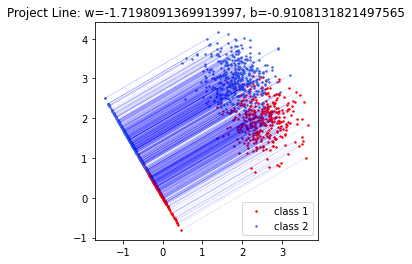

In [260]:
upper_bound = np.max(proj_x_train[:, 0])
lower_bound = np.min(proj_x_train[:, 0])
x = [lower_bound, upper_bound]
slope = w[1] / w[0]
y = [slope*x[0], slope*x[1]]

for i in range(x_train.shape[0]):
    plt.plot(
        [x_train[i, 0], proj_x_train[i, 0]],
        [x_train[i, 1], proj_x_train[i, 1]], lw=0.3, alpha=0.3, c='b')

# data point
plt.scatter(x1[:, 0], x1[:, 1], s=2, c='r', label='class 1')
plt.scatter(x2[:, 0], x2[:, 1], s=2, c='royalblue', label='class 2')

# projected data point
proj_x1_train = proj_x_train[y_train == 0]
proj_x2_train = proj_x_train[y_train == 1]
plt.scatter(proj_x1_train[:, 0], proj_x1_train[:, 1], s=2, c='r')
plt.scatter(proj_x2_train[:, 0], proj_x2_train[:, 1], s=2, c='royalblue')

plt.title(f'Project Line: w={slope}, b={proj_x2_train[0,0]}')
plt.legend(loc='lower right')
plt.gca().set_aspect('equal', adjustable='box')
# plt.savefig('plot.png', dpi=300, transparent=True)
plt.show()